/tmp/ipykernel_15071/2979161492.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['ret'],


Buy and Hold Strategy:
Sharpe Ratio: 0.80
Final Cumulative Return: nan%
Maximum Drawdown: nan%

Dollar-Cost Averaging Strategy:
Sharpe Ratio: 0.02
Final Cumulative Return: 0.60%
Maximum Drawdown: -27.66%


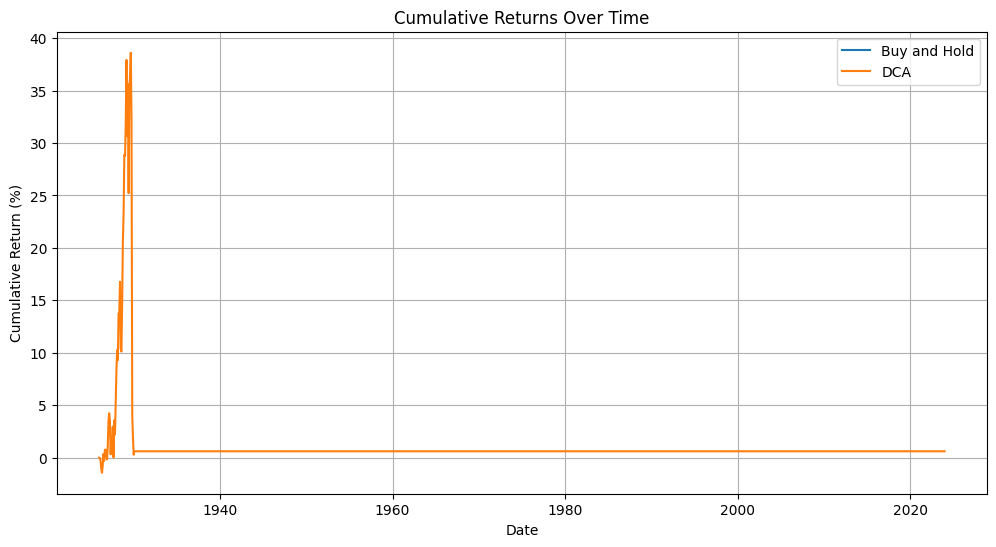

In [3]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

# Cell 2: Load and prepare data
def load_and_prepare_data():
    msf = pd.read_parquet('data_trimmed/crsp.msf_small.parquet')
    msf['date'] = pd.to_datetime(msf['date'])
    msf['mktcap'] = msf['prc'].abs() * msf['shrout']
    msf = msf.sort_values('date')
    msf['ret'] = msf['ret'].fillna(0)
    return msf

# Cell 3: Calculate portfolio metrics
def calculate_metrics(returns, portfolio_values):
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(12)  # Annualized
    cum_returns = (portfolio_values / portfolio_values.iloc[0] - 1) * 100
    roll_max = portfolio_values.cummax()
    drawdowns = portfolio_values / roll_max - 1
    max_drawdown = drawdowns.min() * 100
    return sharpe, cum_returns, max_drawdown

# Cell 4: Buy and Hold Strategy (Corrected)
def buy_and_hold_strategy(data, initial_investment=10000):
    total_mktcap = data.groupby('date')['mktcap'].sum()
    portfolio_returns = (data.groupby('date')
                        .apply(lambda x: np.average(x['ret'], 
                                                  weights=x['mktcap'] / total_mktcap.loc[x['date'].iloc[0]])))
    
    portfolio_values = [initial_investment]
    for ret in portfolio_returns:
        portfolio_values.append(portfolio_values[-1] * (1 + ret))
    portfolio_values = pd.Series(portfolio_values[1:], index=portfolio_returns.index)
    
    return portfolio_returns, portfolio_values

# Cell 5: Dollar-Cost Averaging Strategy
def dca_strategy(data, initial_cash=10000, dca_percentage=0.02):
    dates = data['date'].unique()
    n_periods = len(dates)
    monthly_investment = initial_cash * dca_percentage
    total_mktcap = data.groupby('date')['mktcap'].sum()
    
    portfolio_returns = []
    portfolio_values = [initial_cash]
    shares = 0
    cash = initial_cash
    
    for date in dates:
        current_data = data[data['date'] == date]
        portfolio_ret = np.average(current_data['ret'],
                                 weights=current_data['mktcap'] / total_mktcap.loc[date])
        
        if cash >= monthly_investment:
            investment = monthly_investment
            cash -= investment
            avg_price = current_data['prc'].abs().mean()
            new_shares = investment / avg_price
            shares += new_shares
        
        current_value = shares * avg_price + cash
        portfolio_values.append(current_value)
        
        if len(portfolio_values) > 1:
            ret = (portfolio_values[-1] - portfolio_values[-2]) / portfolio_values[-2]
            portfolio_returns.append(ret)
        else:
            portfolio_returns.append(0)
    
    portfolio_values = pd.Series(portfolio_values[1:], index=dates)
    portfolio_returns = pd.Series(portfolio_returns, index=dates)
    
    return portfolio_returns, portfolio_values

# Cell 6: Main execution and visualization
def main():
    data = load_and_prepare_data()
    bh_returns, bh_values = buy_and_hold_strategy(data)
    dca_returns, dca_values = dca_strategy(data)
    
    bh_sharpe, bh_cum_returns, bh_max_dd = calculate_metrics(bh_returns, bh_values)
    dca_sharpe, dca_cum_returns, dca_max_dd = calculate_metrics(dca_returns, dca_values)
    
    print("Buy and Hold Strategy:")
    print(f"Sharpe Ratio: {bh_sharpe:.2f}")
    print(f"Final Cumulative Return: {bh_cum_returns.iloc[-1]:.2f}%")
    print(f"Maximum Drawdown: {bh_max_dd:.2f}%")
    print("\nDollar-Cost Averaging Strategy:")
    print(f"Sharpe Ratio: {dca_sharpe:.2f}")
    print(f"Final Cumulative Return: {dca_cum_returns.iloc[-1]:.2f}%")
    print(f"Maximum Drawdown: {dca_max_dd:.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.plot(bh_cum_returns, label='Buy and Hold')
    plt.plot(dca_cum_returns, label='DCA')
    plt.title('Cumulative Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Cell 7: Run the analysis
if __name__ == "__main__":
    main()